<a href="https://colab.research.google.com/github/Rakhayeva/Data-Science-Projects-in-English/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taxi Order Forecasting

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The **RMSE metric** on the test set should not exceed 48.

**Project Objectives:**
- [Load](#Loading) the data and resample it by one hour.
- [Analyze](#Analysis) the data.
- [Train](#Train) different models with various hyperparameters. Set the test sample size to 10% of the initial data.
- [Validate](#Validate) the data on the test sample and draw conclusions.
- [General Conclusion](#Conclusion)

**Data Description:**

The data is stored in the `taxi.csv` file. The number of orders is located in the `num_orders` column.

## <a name='Loading'></a> Data Loading

### Libraries and modules import

In [1]:
! pip install catboost -q
! pip install lightgbm -q

In [2]:
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.stattools import adfuller
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor, plot_importance
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Reading

In [3]:
# Reading data, parsing the first column as datetime and setting it as the index
df = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/taxi.csv', parse_dates=[0], index_col=[0])

# Inspecting basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
# Checking the time range
display(df.index.min())
display(df.index.max())

Timestamp('2018-03-01 00:00:00')

Timestamp('2018-08-31 23:50:00')

- Time interval: 10 minutes.
- Period: From March 1st to August 31st, 2018.

Next, we check if the datetime values are in chronological order:

In [6]:
df.index.is_monotonic_increasing

True

The data is ordered chronologically.

In [7]:
# Resampling by one hour
df = df.resample('1h').sum()

## <a name='Analysis'></a> Analysis


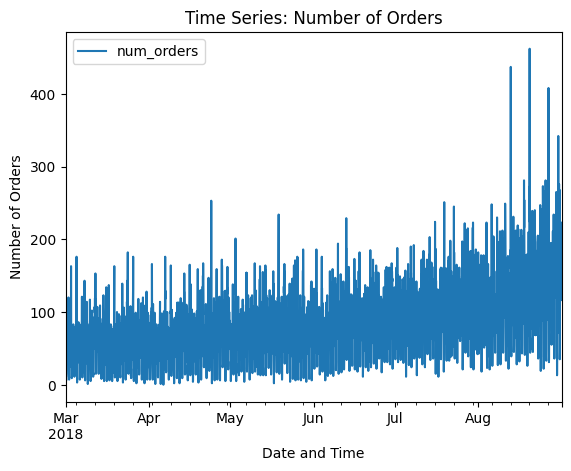

In [8]:
# Plotting the data
df.plot()
plt.title('Time Series: Number of Orders')
plt.xlabel('Date and Time')
plt.ylabel('Number of Orders');

The data looks fairly stationary. Let's add the rolling mean and standard deviation to verify.

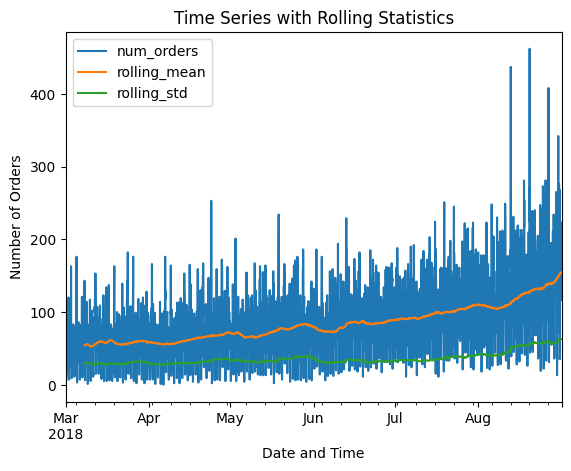

In [9]:
df['rolling_mean'] = df.rolling(24*7).mean()
df['rolling_std'] = df['num_orders'].rolling(24*7).std()

# Plotting again with rolling statistics
df.plot()
plt.title('Time Series with Rolling Statistics')
plt.xlabel('Date and Time')
plt.ylabel('Number of Orders');

We observe a change in the mean and variance towards the end of the graph. The data is non-stationary, but this should not be critical for our models.

We will remove the temporary features and decompose the series into trend, seasonal, and residual components.

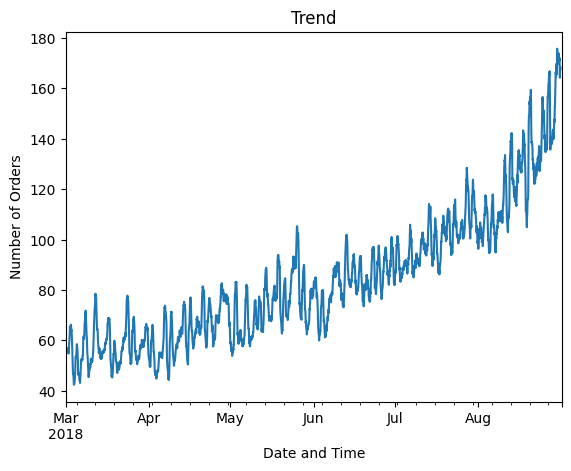

In [10]:
# Removing temporary features
df = df.drop(['rolling_mean', 'rolling_std'], axis=1)

decomposed = seasonal_decompose(df)
decomposed.trend.plot()
plt.title('Trend')
plt.xlabel('Date and Time')
plt.ylabel('Number of Orders');

Fluctuations occur at the weekly level.

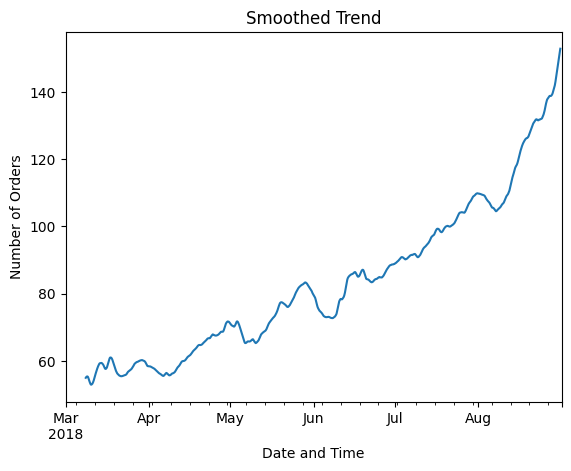

In [11]:
# Smoothing the trend
decomposed.trend.rolling(24*7).mean().plot()
plt.title('Smoothed Trend')
plt.xlabel('Date and Time')
plt.ylabel('Number of Orders');

**There is a clear upward trend**: from March to August, orders tripled. There are minor dips at the beginning of each month and growth towards the end.

### Weekly Seasonality

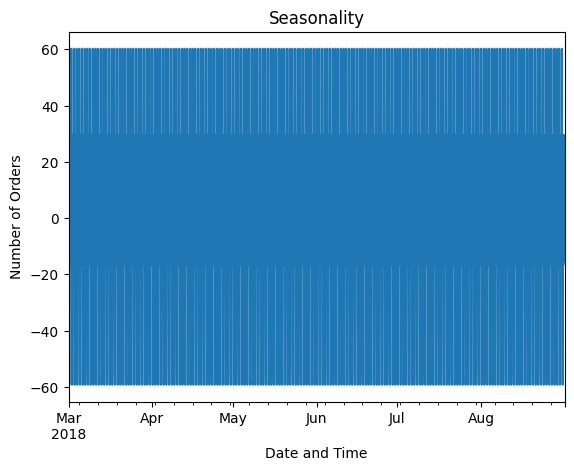

In [12]:
decomposed.seasonal.plot()
plt.title('Seasonality')
plt.xlabel('Date and Time')
plt.ylabel('Number of Orders');

It is difficult to see a clear pattern over the full 5-month period. Let's zoom in on March 2018.

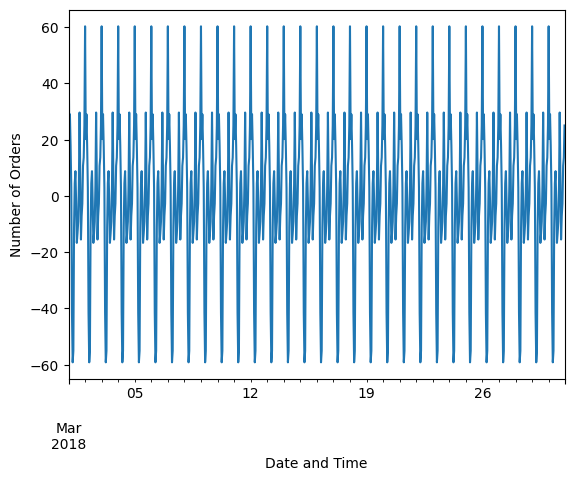

In [13]:
# Seasonal component for March 2018
decomposed.seasonal['2018-03-01':'2018-03-30'].plot()
plt.xlabel('Date and Time')
plt.ylabel('Number of Orders');

Let's try to check the seasonality this week.

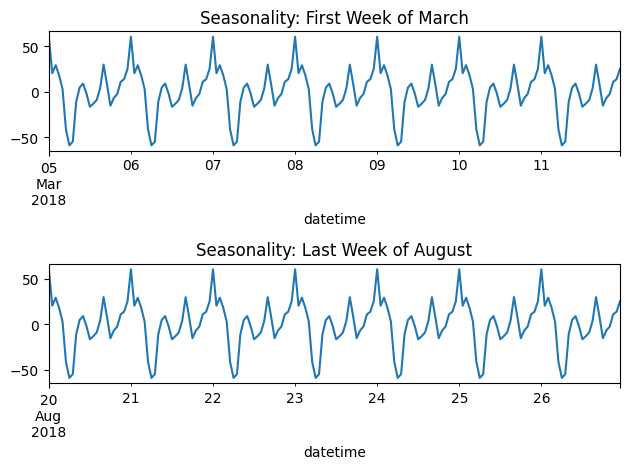

In [14]:
plt.subplot(211)
# Seasonality of the first week of March
decomposed.seasonal['2018-03-05':'2018-03-11'].plot()
plt.title('Seasonality: First Week of March')

plt.subplot(212)
# Seasonality of the last week of August
decomposed.seasonal['2018-08-20':'2018-08-26'].plot()
plt.title('Seasonality: Last Week of August')
plt.tight_layout()

The cycles are consistent. Let's check daily seasonality:

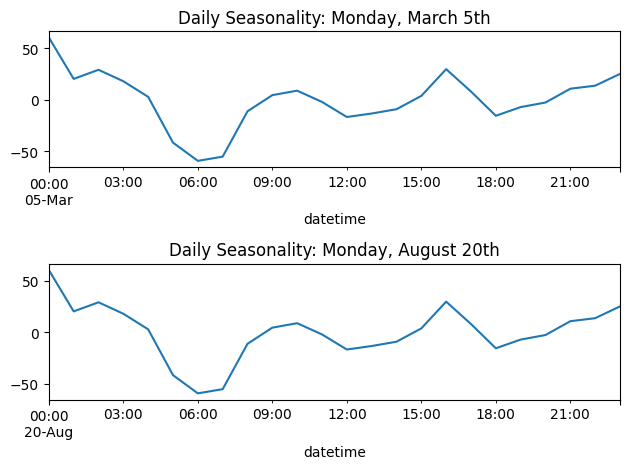

In [15]:
plt.subplot(211)
# Daily seasonality for Monday, March 5th
decomposed.seasonal['2018-03-05'].plot()
plt.title('Daily Seasonality: Monday, March 5th')

plt.subplot(212)
# Daily seasonality for Monday, August 20th
decomposed.seasonal['2018-08-20'].plot()
plt.title('Daily Seasonality: Monday, August 20th')

plt.tight_layout()


- **Growth**: Morning (07:00–10:00), Afternoon (12:00–16:00), and Evening (18:00–00:00). These align with the start/end of the workday and social meetings.
- **Decline**: After the morning rush hour (10:00–12:00), late afternoon (16:00–18:00), and late night (00:00–06:00).
- Midnight Peak: Likely caused by the closing of entertainment venues and reduced availability of public transport.

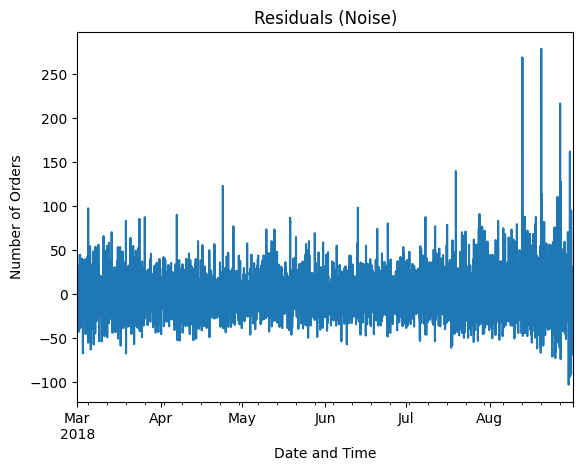

In [16]:
decomposed.resid.plot()
plt.title('Residuals (Noise)')
plt.xlabel('Date and Time')
plt.ylabel('Number of Orders');

- **Large Amplitude**: Residuals show significant fluctuations, especially in August.
- **Heteroscedasticity**: The variance of the noise changes over time (increasing towards August). This violates the assumption of constant variance, which is important for some time-series models.
- **Outliers**: Visible spikes in August are likely significant events rather than errors.

Most likely, these are not errors, but important events.

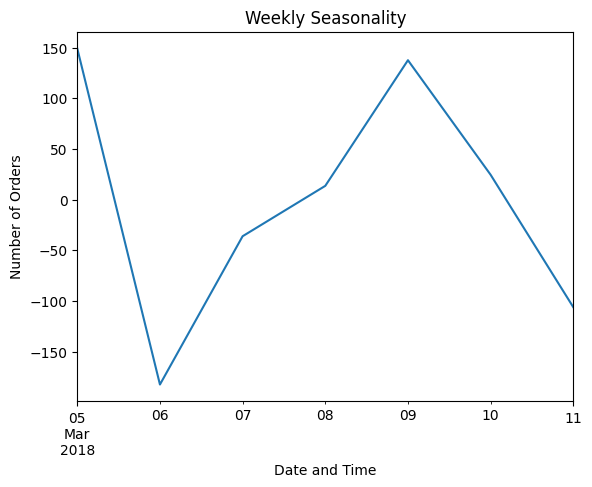

In [17]:
# Copying DataFrame and aggregating by day
week_seasonal = df.copy().resample('1D').sum()
seasonal_decomposed = seasonal_decompose(week_seasonal)
seasonal_decomposed.seasonal['2018-03-05':'2018-03-11'].plot()
plt.title('Weekly Seasonality')
plt.xlabel('Date and Time')
plt.ylabel('Number of Orders');

- **Peaks**: Monday and Friday (commuting days).
- **Low Demand**: Tuesday is the quietest day, with demand gradually increasing until Friday.
- **Weekend**: A decline is observed from Friday through the weekend.

### Analysis Conclusion

- **Trend**: There is a steady upward trend in orders from March to August.
- **Daily Seasonality**: Peaks occur in the morning, afternoon, and late evening (reaching a maximum at midnight), with significant drops during the night.
- **Weekly Seasonality**: Peak demand occurs on Mondays and Fridays, with the lowest demand on Tuesdays.

## <a name='Train'></a> Model Training


### Feature Preparation

We'll create features for the forecast horizon in one step.

In [18]:
def make_features(df):
    df = df.copy() # Avoid SettingWithCopyWarning
    df['dayofweek'] = df.index.dayofweek
    df['day'] = df.index.day
    df['hour'] = df.index.hour

    # Create a list to store lag columns
    lags = []
    for lag in range(1, 169):
        lags.append(df['num_orders'].shift(lag).rename(f'lag_{lag}'))

    # Join all lags at once to avoid fragmentation
    df = pd.concat([df] + lags, axis=1)

    # Rolling mean for daily and weekly seasonality
    df['rolling_mean_24'] = df['num_orders'].shift().rolling(24).mean()
    df['rolling_mean_168'] = df['num_orders'].shift().rolling(168).mean()

    df.dropna(inplace=True)
    return df

In [19]:
# Check data shape before and after feature engineering
display(df.shape)
df = make_features(df)
display(df.shape)

(4416, 1)

(4248, 174)

For time-series forecasting, it is crucial not to shuffle the data to avoid "look-ahead" bias.

In [20]:
X = df.drop('num_orders', axis=1)
y = df['num_orders']

# 10% of the data is reserved for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

### Preprocessing and Pipeline Configuration

We will use a ColumnTransformer to scale numerical features and encode categorical ones.

In [21]:
# Define features for scaling and encoding
numeric_features = ["rolling_mean_24", "rolling_mean_168"]
categorical_features = ["hour", "dayofweek"]

# Define transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features)
    ])

# Create a pipeline for Linear Regression (as it requires scaling/encoding)
linear_regression_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

### Model Definitions and Hyperparameter Tuning

We will compare five different models using TimeSeriesSplit cross-validation.

In [22]:
# Model dictionary
models = {
    "Linear Regression": linear_regression_pipeline,
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "LightGBM": LGBMRegressor(verbosity=-1),
    "CatBoost": CatBoostRegressor(logging_level='Silent')
}

# Hyperparameter grids for GridSearchCV
param_grids = {
    "Linear Regression": {},
    "Decision Tree": {
        "max_depth": [5, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [10, 100, 150],
        "max_depth": [5, 10]
    },
    "LightGBM": {
        "n_estimators": [50, 100],
        "learning_rate": [0.05, 0.1],
        "max_depth": [5, 10]
    },
    "CatBoost": {
        "learning_rate": [0.1, 0.2, 1],
        "depth": [5, 10]
    }
}

# Cross-validation strategy for Time Series
tscv = TimeSeriesSplit(n_splits=3)

# Dictionary and list to store the best models and overall results
best_models = {}
results = []

for name, model in models.items():
    print(f"Training {name}...")
    grid_search = GridSearchCV(model, param_grids[name], scoring="neg_root_mean_squared_error", cv=tscv)
    grid_search.fit(X_train, y_train)

    # Save the best estimator
    best_models[name] = grid_search.best_estimator_

    # Extract the best RMSE score (GridSearchCV returns negative RMSE)
    best_rmse = abs(grid_search.best_score_)

    # Append results for final comparison
    results.append({
        "Model": name,
        "Best Parameters": grid_search.best_params_,
        "Best Score (RMSE)": best_rmse
    })

# Display results table
results_df = pd.DataFrame(results)
display(results_df)

Training Linear Regression...
Training Decision Tree...
Training Random Forest...
Training LightGBM...
Training CatBoost...


,Model,Best Parameters,Best Score (RMSE)
0,Linear Regression,{},26.852224
1,Decision Tree,"{'max_depth': 5, 'min_samples_split': 10}",28.813148
2,Random Forest,"{'max_depth': 10, 'n_estimators': 150}",23.802068
3,LightGBM,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",23.611870
4,CatBoost,"{'depth': 5, 'learning_rate': 0.1}",24.281582


LightGBM showed the best result (RMSE: 23.6), followed by Random Forest (23.8) and CatBoost (24.3). All models satisfy the RMSE ≤ 48 condition, so LightGBM is better for forecasting.

## <a name='Validate'></a> Validation

In [23]:
# Final training of the best LightGBM model on the full training set
lightgbm = best_models['LightGBM']
lightgbm.fit(X_train, y_train)

# Predictions on the test set
y_pred = lightgbm.predict(X_test)

# RMSE Calculation
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE on the test set: {final_rmse:.2f}")

Final RMSE on the test set: 36.80


The final RMSE on the test sample is 36.8, which satisfies the problem condition, although the gap between the training and the test samples is quite large.

### Baseline Comparison

To understand the quality of our model, we compare its performance against simple baselines:
- **Lag 24 Baseline**: Predicts the number of orders using the value from the same hour of the previous day.
- **Lag 168 Baseline**: Predicts the number of orders using the value from the same hour and same day of the previous week.

In [24]:
# Lag 24 - Prediction based on the same hour from the previous day
baseline_lag_24 = X_test['lag_24']

# Lag 168 - Prediction based on the same hour/day from the previous week
baseline_lag_168 = X_test['lag_168']

# RMSE calculation for Baselines
rmse_lag_24 = np.sqrt(mean_squared_error(y_test, baseline_lag_24))
rmse_lag_168 = np.sqrt(mean_squared_error(y_test, baseline_lag_168))

print(f"RMSE for Lag 24 Baseline: {rmse_lag_24:.2f}")
print(f"RMSE for Lag 168 Baseline: {rmse_lag_168:.2f}")

RMSE for Lag 24 Baseline: 55.86
RMSE for Lag 168 Baseline: 39.29


On the test set, LightGBM maintained strong performance with a final RMSE of 36.80, which significantly outperforms the simple baseline models. Thus, it effectively captures the underlying patterns in the data better than simple historical shifts and is the most suitable model for deployment.

## <a name='Conclusion'></a> General Conclusion

In this project, we processed historical taxi order data for Sweet Lift Taxi at airports from March to August 2018. The initial data, recorded at 10-minute intervals, was resampled to one-hour intervals and checked for missing values (none were found).

**Time Series Analysis Findings:**
- Trend: There is a consistent upward trend in the number of orders from March through August.
- Seasonality:
   - Daily: A slump in orders occurs after midnight, followed by growth in the morning and evening, peaking around midnight.
   - Weekly: Demand peaks on Mondays and Fridays. It grows from Tuesday to Friday and declines from Friday through the weekend.
   
- Outliers: Notable spikes in orders were observed, particularly in August, likely due to special seasonal events.
- Stationarity: Visual and statistical assessment confirmed that the series is non-stationary, showing increasing mean and variance over time.

**Modeling and Performance:**

Several models were trained with hyperparameter tuning, including Linear Regression, Decision Tree, CatBoost, LightGBM, and Random Forest:
- LightGBM demonstrated the best performance during cross-validation (**RMSE: 23.6**).
- Random Forest and CatBoost also showed strong results (**RMSE: 23.8 and 24.3** respectively).
- The final evaluation of the LightGBM model on the test set yielded an **RMSE of 36.8**, which successfully meets the project requirement ($RMSE \leq 48$).

While there is a visible gap between training and testing RMSE (indicating some overfitting), the model provides sufficient accuracy to be used in production for predicting taxi demand for the next hour.